<a href="https://colab.research.google.com/github/fraison/HNN/blob/master/LearningHamiltonian3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First: Make sure GPUs are enabled in this notebook from Edit->Notebook Settings.

# Here we use a Hamiltonian NN to predict the trajectory of a particle

In [ ]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

In [ ]:
n_coordinates = 2
hidden = 400

# Let's set up a simulation of a 2D falling ball, launched at a random speed: 3000 launches iterated over 300 steps

In [ ]:
N = 3000
p0 = np.random.rand(N, 2)
v0 = np.random.rand(N, 2)

In [ ]:
p = []#position not p but x
v = []#velocity
T = 300
#m=1, g= 9.81
cp = p0
cv = v0
for _ in range(T):
  cp = cp + cv*0.01
  cv = cv + 0.01*(-9.81)*np.array([0, 1])[np.newaxis, :]

  p.append(cp)
  v.append(cv)

p = np.array(p).transpose(1, 0, 2)
v = np.array(v).transpose(1, 0, 2)

In [ ]:
print(p.shape)


(3000, 300, 2)


# Here's a bunch of trajectories with random initial conditions:

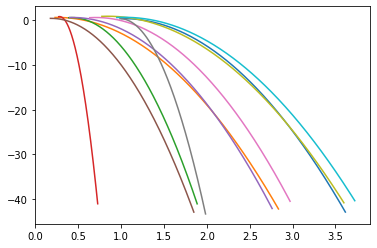

In [ ]:
for i in range(10):
  plt.plot(p[i, :, 0], p[i, :, 1])

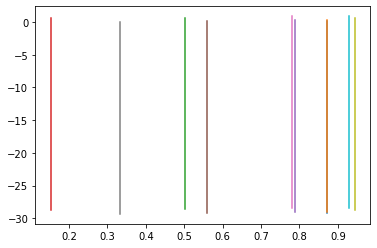

In [ ]:
for i in range(10):
  plt.plot(v[i, :, 0], v[i, :, 1])

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Let's take the derivative of the neural network to use as our parameter updates:

In [ ]:
tp = torch.from_numpy(p.astype(np.float32)).cuda()
tv = torch.from_numpy(v.astype(np.float32)).cuda()

#Arrange into [v0, v1, x0, x1] - X et y canonical shifted from 1 delta_t
X = torch.cat((tp[:, :-1], tv[:, :-1]), dim=2)[..., [2, 3, 0, 1]]
y = torch.cat((tp[:, 1:], tv[:, 1:]), dim=2)[..., [2, 3, 0, 1]]



M = torch.eye(n_coordinates*2).cuda()
M = torch.cat([M[n_coordinates:], -M[:n_coordinates]])
print(str(M))

# Base model (calculates H)
act = nn.Softplus
model = nn.Sequential(
    nn.Linear(n_coordinates*2, hidden), act(),
    nn.Linear(hidden, hidden), act(),
    nn.Linear(hidden, hidden), act(),
    nn.Linear(hidden, 1)
).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
print(str(model.parameters))
# Differentiates H and returns the derivatives of the canonical variables:
def canonical_model(cX):
  cX = torch.autograd.Variable(cX, requires_grad=True)
  # The final matrix multiply (@) here simply moves dH/dx to pdot, and dH/dp to xdot.
  return torch.autograd.grad(model(cX).sum(), cX, create_graph=True)[0] @ M.t()

tensor([[ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.],
        [-1., -0., -0., -0.],
        [-0., -1., -0., -0.]], device='cuda:0')
<bound method Module.parameters of Sequential(
  (0): Linear(in_features=4, out_features=400, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=400, out_features=1, bias=True)
)>


Here a sample of the training set

In [ ]:
mX = torch.cat((tp[0:2, :299,:], tv[0:2, :299,:]), dim=2)[..., [2, 3, 0, 1]]
my = torch.cat((tp[0:2, 1:300,:], tv[0:2, 1:300,:]), dim=2)[..., [2, 3, 0, 1]]
mX.shape

torch.Size([2, 299, 4])

# Here we set up our dataset to train on :

In [ ]:
trainset = TensorDataset(X[:N*3//4*300].reshape(-1, 4), y[:N*3//4*300].reshape(-1, 4))
testset = TensorDataset(X[N*3//4*300:].reshape(-1, 4), y[N*3//4*300:].reshape(-1, 4))
train = DataLoader(trainset, shuffle=True, batch_size=512)
test = DataLoader(testset, shuffle=False, batch_size=512)

In [ ]:
loss_fn = nn.MSELoss()
print(N*3//4*300)
print(X.shape)
print(testset.__sizeof__())



675000
torch.Size([3000, 299, 4])
32


Training

In [ ]:
for _ in range(20):
  all_loss = 0.0
  for (cX, cy) in train:
    test_y = canonical_model(cX)
    loss = loss_fn(test_y, cy-cX)
    loss.backward()
    opt.step()
    opt.zero_grad()
    all_loss += loss.item()*512

  print(all_loss/len(trainset))

1.3210810804975313e-07
1.0892249800361459e-07
1.0783416183933137e-07
1.0784479896997554e-07
1.0315877371554767e-07
9.658423787876092e-08
1.0287991267711347e-07
8.194776309024734e-08
8.50194211559161e-08
8.38849501940597e-08
8.29222461546883e-08
7.872904183419154e-08
7.705621302865556e-08
7.474769639480927e-08
7.042483796712712e-08
6.946549044532872e-08
6.74051820805286e-08
6.742181076480528e-08
6.604953061343405e-08
6.370227733333441e-08


Here we can look at the prediction:

In [ ]:
for (cX, cy) in test:
  test_y = canonical_model(cX)
  print(cy.shape)
  break


In [ ]:
test_y, cy - cX

(tensor([[-8.7453e-05, -9.8379e-02,  3.5818e-03, -2.2254e-01],
         [-6.4587e-05, -9.8331e-02,  6.7226e-04, -2.3234e-01],
         [ 5.4296e-06, -9.8217e-02,  6.7562e-03, -1.6710e-01],
         ...,
         [-1.1633e-04, -9.8343e-02,  4.1245e-03, -2.5161e-01],
         [-1.5641e-05, -9.8252e-02,  6.1306e-03, -9.0914e-02],
         [ 1.0695e-05, -9.8200e-02,  8.8644e-03, -4.6900e-02]], device='cuda:0',
        grad_fn=<MmBackward>), tensor([[ 0.0000, -0.0981,  0.0037, -0.2216],
         [ 0.0000, -0.0981,  0.0008, -0.2315],
         [ 0.0000, -0.0981,  0.0069, -0.1664],
         ...,
         [ 0.0000, -0.0981,  0.0043, -0.2503],
         [ 0.0000, -0.0981,  0.0062, -0.0904],
         [ 0.0000, -0.0981,  0.0089, -0.0465]], device='cuda:0'))

# As we can see, the Hamiltonian NN has very closely learned the dynamics with very little training

# Homework problems:
0. Plot the resultant trajectories of a HNN.
1. Plot H over the relevant parameter space. Create a vector field showing its predicted path.
2. Write an RK4 method for this neural network.

run HNN on sample

In [ ]:

mmX = mX.cpu()
print(mmX.shape)
mmy = my.cpu()
#run forward
mtest_y = canonical_model(mX)
mmtest_y = mtest_y.cpu()
print(mmtest_y.shape)

(mmX[0,:, 3]+mmtest_y[0,:, 3]).shape

torch.Size([2, 299, 4])
torch.Size([2, 299, 4])


torch.Size([299])

torch.Size([488, 4])
torch.Size([488, 4])
torch.Size([2, 299, 4])
torch.Size([299])
torch.Size([299])
torch.Size([2, 299, 4])


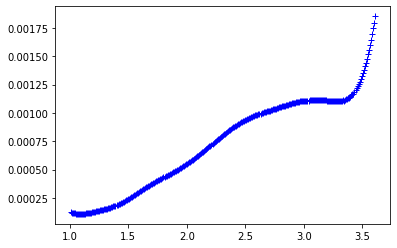

In [ ]:
print(cy.shape)
print(test_y.shape)
print(mtest_y.shape)

# Prediction error on y vs x
a= mmX[0,:, 2]
b =mmtest_y[0,:, 3]-(mmy[0,:, 3]-mmX[0,:, 3])
print(a.shape)
print(b.shape)
print(mmy.shape)
plt.plot(a,b.detach().numpy(),"b+")
#print(b.detach().numpy())
#print(mmy[0,:, 3].detach().numpy())


QUESTION 0

tensor([0.8722, 0.0302, 1.0159, 0.4179], device='cuda:0')
tensor([-7.5828e-05, -9.7896e-02,  8.7821e-03,  1.4049e-03], device='cuda:0',
       grad_fn=<SqueezeBackward3>)
torch.Size([299, 4])
[[ 8.7220657e-01  1.2833208e-01  1.0072142e+00  4.1664666e-01]
 [ 8.7213075e-01  3.0436248e-02  1.0159962e+00  4.1805160e-01]
 [ 8.7206006e-01 -6.7460261e-02  1.0247804e+00  4.1847512e-01]
 ...
 [ 8.8037276e-01 -2.8832212e+01  3.6137950e+00 -4.1715534e+01]
 [ 8.8050997e-01 -2.8930431e+01  3.6226919e+00 -4.2002048e+01]
 [ 8.8064426e-01 -2.9028688e+01  3.6315870e+00 -4.2289490e+01]]


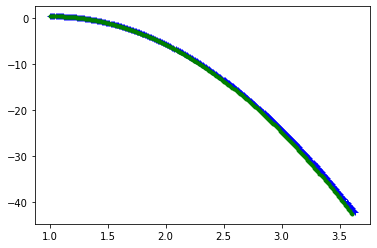

In [ ]:
#QUESTION 0: 2 trajectories from training sample 
# need to iterate from an initial value and compare to train
dp1_ref = mmX[0,:, 2]
dp2_ref = mmX[0,:, 3]

imtest_y = canonical_model(mX[0,0,:])
print(my[0,0,:])
print(imtest_y)

#trajFromHNN=  torch.tensor(mX[0,:,:])
trajFromHNN=  mX[0,:,:].clone()#.detach()
#trajFromHNN.new_zeros(mX[0,:,:])

trajFromHNN[0,:] = mX[0,0,:]
print(trajFromHNN.shape)

for i in range(0,298):
  trajFromHNN[i+1,:]=canonical_model(trajFromHNN[i,:])+trajFromHNN[i,:]

ctrajFromHNN=trajFromHNN.cpu().detach().numpy()
plt.plot(ctrajFromHNN[:, 2], ctrajFromHNN[:, 3],"b+",mmX[0,:, 2],mmX[0,:, 3],"g.")
print(ctrajFromHNN)

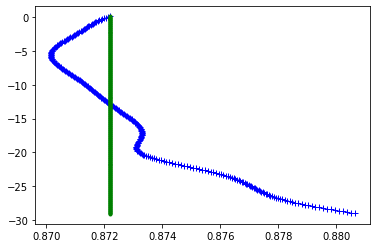

In [ ]:
plt.plot(ctrajFromHNN[:, 0], ctrajFromHNN[:, 1],"b+",mmX[0,:, 0],mmX[0,:, 1],"g.")

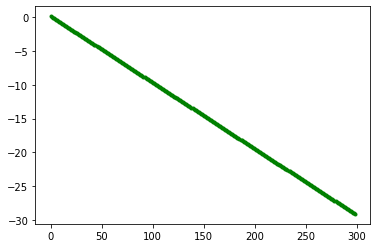

In [ ]:
plt.plot(mmX[0,:, 1],"g.")#vy

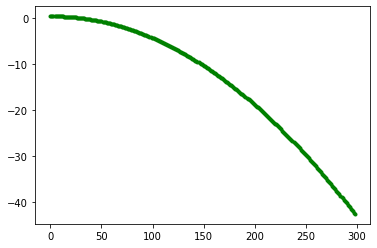

In [ ]:
plt.plot(mmX[0,:, 3],"g.")#y

QUESTION 1

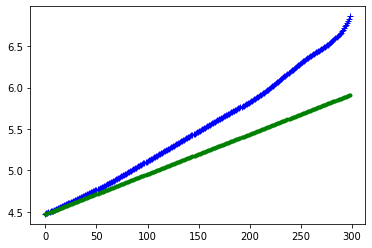

In [ ]:
#Question 1: Energy
def hamiltonian_fn(p1,p2,v1,v2):
    H = 0.5*(v1**2 +v2**2) +9.81*(p2)  # free fall H= 1/(2.m).p**2+m.g.y
    return H



H_true = hamiltonian_fn(mmX[0,:, 2],mmX[0,:, 3],mmX[0,:, 0],mmX[0,:, 1])
H_res =  hamiltonian_fn(ctrajFromHNN[:, 2], ctrajFromHNN[:, 3],ctrajFromHNN[:, 0], ctrajFromHNN[:, 1])
plt.plot(H_res,"b+",H_true,"g.")

rem

torch.Size([488, 4])
tensor([[ 8.9345e-01, -7.2153e+00,  1.1662e+00, -2.5676e+00],
        [ 9.8232e-01, -4.3587e+00,  1.4321e+00, -2.5308e-02],
        [ 1.7329e-01, -1.3528e+01,  3.6728e-01, -8.6198e+00],
        [ 4.1592e-01, -1.2030e+01,  9.0874e-01, -6.4632e+00],
        [ 8.0374e-01, -2.7444e+01,  3.0222e+00, -3.7731e+01],
        [ 6.2176e-01, -1.6745e+01,  1.3880e+00, -1.3513e+01],
        [ 3.5348e-01, -9.0294e+00,  8.5518e-01, -3.4640e+00],
        [ 5.6384e-01, -2.5487e+01,  2.2254e+00, -3.2347e+01],
        [ 3.9172e-01, -2.4730e+01,  1.3574e+00, -3.0448e+01],
        [ 4.9197e-01, -4.2067e+00,  4.5143e-01,  7.5146e-02]])
tensor([], size=(2, 0), dtype=torch.int64)


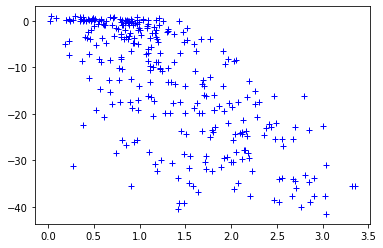

In [ ]:
#Note that the DataLoader is mixing everything

#mycx+ test_y and mycy 
mycy=cy.cpu()
mycx = cX.cpu()

print(mycx.shape)
print(mycx[:10,:])

plt.plot(mycx[:300, 2], mycx[:300, 3],"b+")